In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

In [ ]:
data = pd.read_csv(r'C:\Users\giuli\Documents\GitHub\Progetto_BI2021\data.csv', parse_dates=['created_at'])
df = pd.DataFrame(data)

## DECODING DEL TESTO ALL INTERNO DELLA COLONNA `text`. 
All interno della colonna text è presente una rappresentazione di un bytes sotto forma di stringa. Questa può essere valutata attraverso la funzione `ast.literal_eval(string)` e quindi decodificata
#secondo la codifica appropriata tramite il metodo decode

In [ ]:
text_enc = []
for i in range(0, df.text.size):
    txt= ast.literal_eval(df.text[i]).decode('utf-8')
    text_enc.append(txt)

df['text_enc'] = text_enc
df

## Pulizia dei Tweet
Attraverso le Regular Expressions vado a rimuovere elementi come:
* @menzioni
* Hashtag
* Link

In [ ]:
import re

def cleanTxt(text):
 text=text.lower()
 text = re.sub('\S*trump\S*', 'trump', text)
 text = re.sub('\S*biden\S*', 'biden', text)
 text = re.sub('\S*clinton\S*', 'clinton', text)
 text = re.sub('@\S+', '', text) #Rimuove le @menzioni
 text = re.sub('#', '', text) # Rimuove l'hashtag
 text = re.sub('https?:\/\/\S+', '', text) # Rimuove i link
 text = re.sub('&amp', '', text) #Rimuove &amp
 text = re.sub('covid-19', 'covid', text ) #converte covid-19 in covid
 text = re.sub('covid19', 'covid', text ) #converte covid19 in covid
 text = re.sub('covid 19', 'covid', text ) #converte covid 19 in covid
 text = re.sub('coronavirus', 'covid', text)
 return text

def countMentions(text):
    return len(re.findall('@\S+', text))

def countHashtags(text):
    return len(re.findall('#', text))

def countLinks(text):
    return len(re.findall('https?:\/\/\S+', text))


df.text_enc=df.text_enc.astype('str')
df['text_clean'] = df.text_enc.apply(cleanTxt)
df['mentions'] = df.text_enc.apply(countMentions)
df['hashtags'] = df.text_enc.apply(countHashtags)
df['links'] = df.text_enc.apply(countLinks)


In [ ]:
df

## Language Detection
il metodo `detect_langs` fornisce un vettore di possibilità riguardo la lingua del testo che sta analizzando. Vado a vedere se ci sono nel dataset testi ambigui (quindi quelli per cui la dimensione del `dict` ritornato da `detect_langs` è maggiore di 1).

Utilizzo `langdetect` che è abbastanza veloce per generare una previsione sommaria. Esso restituisce la probabilità per ciascuna lingua trovata quindi:
* se trovo una sola lingua tra quelle ammesse (en, es, fr) allora segno la lingua trovata e segno la detection come sicura
* se trovo più di una lingua oppure trovo come lingua più probabile una non ammessa segno la lingua e segno la detection come insicura/sbagliata (`unsure_wrong_detection=True`) 

In [ ]:
from langdetect import detect_langs

unsure_count = 0
wrong_count = 0
i=0
lang_detect = []
unsure_wrong = []

for twt in df.text_enc:
    try:
        detection = detect_langs(twt)
        lang = detection[0].lang
        
        lang_detect.append(lang)
        unsure_wrong.append(False)
        
        if((lang != "en") and (lang != "es") and (lang != "fr")):
             wrong_count = wrong_count +1
             unsure_wrong[i]=True
        if(len(detection)>1):
            unsure_wrong[i]=True
            unsure_count = unsure_count+1

    except:
        print("errore alla posizione ")
        i
        print("testo : " + twt)
        lang_detect.append('None')
        unsure_wrong.append(True)

    i=i+1



df['langdetect']=lang_detect
df['unsure_wrong_detection'] = unsure_wrong

unsure_wrong_sum = df['unsure_wrong_detection'].sum()
unsure_wrong_sum

# Check traduzione attraverso API Google 
I tweet dei quali la traduzione non è sicura sono stati marcati con un `True` all'interno della colonna `unsure_wrong_detection`. Utilizzo questa informazione per passare i questi tweet all'interno dell'API Google per la traduzione. Questo metodo non è stato utilizzato prima in quanto le possibili chiamate ai server Google sono limitate e molto lente.

In [ ]:
from textblob import TextBlob

lang_detect_final = []
i = 0
for twt in df.text_clean:
    if not df['unsure_wrong_detection'][i]:
        lang_detect_final.append(df['langdetect'][i])
    else:
        blob = TextBlob(twt)
        lang = blob.detect_language()
        if((lang != "en") and (lang != "es") and (lang != "fr")):
            lang_detect_final.append('None')
        else:
            lang_detect_final.append(lang)
            df['unsure_wrong_detection'][i]=False
    i=i+1

df['lang_detect_final'] = lang_detect_final

In [ ]:
df.unsure_wrong_detection.sum() #numero totale di tweet di cui non è stata identificta la lingua

## Esportazione dei dati su formato Excel
Excel non supporta le date con le timezone quindi le ho dovute eliminare con il metodo `datetime.tz_localize()`

In [ ]:
df_enc = df[['favorite_count', 'source', 'text_enc', 'text_clean', 'is_retweet', 'retweet_count', 'created_at', 'langdetect' , 'unsure_wrong_detection', 'lang_detect_final']]
df_enc.loc[:,'created_at_ntz']= df_enc.created_at.dt.tz_localize(None)

df_enc = df_enc.drop(columns='created_at')
df_enc.to_excel('data_dec.xlsx')

# Inizio dell'analisi
Dopo aver salvato i dati ripuliti all'interno del file Excel, uso questo come checkpoint per partire con l'analisi. Questo perché non è sempre possibile performare di nuovo la traduzione a causa delle restrizioni dell'api di Google descritte sopra

Dal momento che i Tweet la cui lingua non è stata riconosciuta sono meno dell' 1%, questi vengono filtrati. Dopodiché il dataset viene splittato per lingua in tre ```DataFrame``` 


In [ ]:
data=pd.read_excel(r'C:\Users\giuli\Documents\GitHub\Progetto_BI2021\data_dec.xlsx')
df=pd.DataFrame(data)

df = df.drop(columns='langdetect')
df.loc[df['unsure_wrong_detection']==True].shape #controllo dei tweet la cui lingua non è stata riconosciuta
df = df.loc[df['unsure_wrong_detection']==False] #filtraggio dei tweet non riconosciuti

### Suddivisione dei Dataset per lingua ###

#en
df_en = df.loc[df['lang_detect_final']=='en']
df_en = df_en.drop(columns=['lang_detect_final', 'unsure_wrong_detection'])

#es
df_es = df.loc[df['lang_detect_final']=='es']
df_es = df_es.drop(columns=['lang_detect_final', 'unsure_wrong_detection'])

#fr
df_fr = df.loc[df['lang_detect_final']=='fr']
df_fr = df_fr.drop(columns=['lang_detect_final', 'unsure_wrong_detection'])


In [ ]:
#questo blocco di codice è inutile se si fanno runnare tutti i blocchi dall'inizio

df_en.text_enc=df_en.text_enc.astype('str')
df_en['text_clean'] = df_en.text_enc.apply(cleanTxt)
df_en['mentions'] = df_en.text_enc.apply(countMentions)
df_en['hashtags'] = df_en.text_enc.apply(countHashtags)
df_en['links'] = df_en.text_enc.apply(countLinks)

df_en.to_excel('dataen.xlsx')

## Preprocessing del testo
Attraverso la libreria ```nltk``` viene effettuato il preprocessing del testo. Ogni tweet viene tokenizzato in parole che vengono filtrate dalle stopwords e stemmate attraverso il ```PorterStemmer```. I tweet, una volta stemmati vengono salvati nella colonna text_stem e quindi per comodità de-tokenizzati.

In [ ]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

df_en.text_clean=df_en.text_clean.astype('str')

text_stem = []
#df_en['text_clean']=df_en['text_clean'].astype('str')

for twt in df_en.text_clean:
    tweet = twt.lower()
    token_words = word_tokenize(tweet) #tokenizzazione
    token_filter_words = [w for w in token_words if not w in stop_words] #stopword filtering
    stem_sentence=[]
    for word in token_filter_words:
        stem_sentence.append(porter.stem(word)) #stemming
        stem_sentence.append(' ')
    
    text_stem.append(''.join(stem_sentence))

df_en['text_stem']=text_stem

## Tf-Idf
A questo punto viene performata la Tf-Idf sui tweet stemmati al punto precedenti. 

La Tf-idf viene effettuata utilizzando il parametro ```min_df``` che filtra le parole in base alla loro frequenza nel dataset: se ```min_df=0.005``` allora verranno filtrate tutte le parole che compaiono in meno del 0,5% dei tweet. Questo permette di ridurre drasticamente il numero di feature e l'analisi verrà effettuata utilizzando varie percentuali minime. Il parametro ```max_df``` è l'analogo per la frequenza massima. 

Per comodità di visualizzazione viene creato un dataframe per visualizzare la matrice tf-idf e generare una classifica delle parole: lo score di ciascuna parola è la media del tf-idf della parola in tutti i tweet. Vengono visualizzati i termini con score maggiore.

In [151]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(data, mindf,  lan='english'):

    tfidfVectorizer = TfidfVectorizer(min_df=mindf,
                                    stop_words=lan)
    tfidf_matrix = tfidfVectorizer.fit_transform(data['text_stem'])

    print("sono state prodotte", len(tfidfVectorizer.get_feature_names()), "parole nel processo di tf-idf con mindf=", mindf)
    ## Conversione TfIdf in Dataframe ##

    # tfidfVectorizer ritorna una matrice sparsa che non permette la visualizzazione agevole della matrice TfIdf

    tf_idf = pd.DataFrame(columns=tfidfVectorizer.get_feature_names(), index=data['text_clean'], dtype=float)
    
    M=tfidf_matrix.todense()
    for i in range(0, data.shape[0]):
        tf_idf.iloc[i, :]=M[i,:]

    ## classifica delle parole
    #score={}
    #for word in tfidfVectorizer.get_feature_names():
    #    score[word]= tf_idf_en[word].mean()

    #score_sroted = dict(sorted(score.items(), key=lambda item: item[1], reverse=True))
    #print("Score delle prime 10 parole: ", list(score_sroted.items())[0:10])

    return tf_idf, M



sono state prodotte 412 parole nel processo di tf-idf con mindf= 0.005


In [153]:
tf_idf_en, tfidf_en_matrix=tfidf(df_en, 0)
tf_idf_en, tfidf_en_matrix=tfidf(df_en, 0.001)
tf_idf_en, tfidf_en_matrix=tfidf(df_en, 0.005)
tf_idf_en, tfidf_en_matrix=tfidf(df_en, 0.01)
tf_idf_en, tfidf_en_matrix=tfidf(df_en, 0.05)

sono state prodotte 8025 parole nel processo di tf-idf con mindf= 0
sono state prodotte 1788 parole nel processo di tf-idf con mindf= 0.001
sono state prodotte 412 parole nel processo di tf-idf con mindf= 0.005
sono state prodotte 167 parole nel processo di tf-idf con mindf= 0.01
sono state prodotte 6 parole nel processo di tf-idf con mindf= 0.05


## Scelta del numero di feature
Proseguo l'analisi con una mindf di 0.001, 0.005 e 0.01

In [166]:
tf_idf_en_01, tfidf_en_matrix_01 = tfidf(df_en, 0.001)
tf_idf_en_05, tfidf_en_matrix_05 = tfidf(df_en, 0.005)
tf_idf_en_10, tfidf_en_matrix_10 = tfidf(df_en, 0.01)

tf_idf_en_00, tfidf_en_matrix_00 = tfidf(df_en, 0)

sono state prodotte 1788 parole nel processo di tf-idf con mindf= 0.001
sono state prodotte 412 parole nel processo di tf-idf con mindf= 0.005
sono state prodotte 167 parole nel processo di tf-idf con mindf= 0.01
sono state prodotte 8025 parole nel processo di tf-idf con mindf= 0


In [157]:
tfidf_en_matrix_01

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.48543603, 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

## PCA vs ```min_df```
Provo a ridurre le features non alla cieca come il parametro ```min_df``` della Tf Idf ma preservando le informazioni all'interno del dataset.
La PCA è giustificata dalla non necessità di interpretare le feature.

In [169]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
def feature_redux(M):
    original_size=M.shape[1]
    #Standardizzo i dati
    scaler = StandardScaler()
    M = scaler.fit_transform(M)

    #Applico la PCA mantenendo il 95% della varianza
    pca=PCA(0.90)
    M = pca.fit_transform(M)

    print("Il numero di feature è stato ridotto da ",original_size,"a", pca.n_components_)

    #scatter 3d dei punti prodotti
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import pyplot

    figure = pyplot.figure()
    ax = Axes3D(figure)

    ax.scatter(M[:,0], M[:,1], M[:,2])
    pca.explained_variance_
    pyplot.show()

    return M


Il numero di feature è stato ridotto da  8025 a 1879
<ipython-input-169-78de51b762a6>:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(figure)


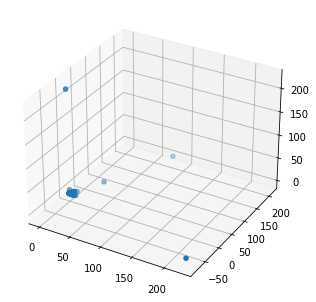

array([[-0.24814581, -0.17015863, -0.11764518, ...,  0.22183564,
        -0.68555571, -0.2848627 ],
       [-0.09228644,  0.0935039 , -0.0848946 , ..., -1.92565282,
        -2.8743332 , -3.7817251 ],
       [-0.17788125, -0.11831102, -0.07620139, ..., -0.99185881,
         0.85087386,  2.00034543],
       ...,
       [-0.24813396, -0.11462776,  0.30316702, ...,  0.55022213,
        -0.35707112,  0.63207769],
       [-0.42670141, -0.25946514, -0.18706302, ...,  0.02622071,
        -0.34782221,  0.05407684],
       [-0.23394214, -0.19545702, -0.12527617, ..., -0.46163505,
        -0.37289294,  0.23249225]])

In [170]:
feature_redux(tfidf_en_matrix_00)

# K-means Clustering
Viene performato un algoritmo di K-means Clustering, valutando i valori di K e plottando la Sum of Square Differences.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

SSD = []
K=range(10,40)

for k in K:
    print("Kmeans clustering con k = %d", k)
    km=KMeans(n_clusters=k, max_iter=300, n_init=20)
    km = km.fit(tfidf_en_matrix)
    SSD.append(km.inertia_)

plt.plot(K, SSD, 'bx-')

In [ ]:
SSD

Si sceglie un valore di k=5, si performa il clustering e si aggiunge l'informazione di labeling al dataframe

In [ ]:
k=50

model = KMeans(n_clusters=k, max_iter=300, n_init=20)
model.fit(tfidf_en_matrix)

df_en['label_kmeans']=model.labels_


In [ ]:

from wordcloud import WordCloud

frequent_words=['covid']

df_en_0 = df_en.loc[df_en['label_kmeans']==1]
text = df_en_0['text_clean'].str.cat(sep='')
text = text.lower()
text=' '.join([word for word in text.split() if not word in frequent_words])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig1 = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)

## Esaminazione dei cluster

In [ ]:
#visualizzazione dei centroidi tramite PCA

M = model.cluster_centers_

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#Standardizzo i dati
scaler = StandardScaler()
M = scaler.fit_transform(M)

#Applico la PCA mantenendo le prime 3 componenti
pca=PCA(n_components=3)
M = pca.fit_transform(M)

#scatter 3d dei centroidi prodotti
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

figure = pyplot.figure()
ax = Axes3D(figure)

ax.scatter(M[:,0], M[:,1], M[:,2])
pca.explained_variance_

pyplot.show()

# Utilizo del DB-SCAN per raggruppare i cluster

In [101]:
from sklearn.cluster import DBSCAN
M= model.cluster_centers_
pca=PCA(0.95)
M= pca.fit_transform(scaler.fit_transform(M))

clustering = DBSCAN(eps=1, metric='cosine').fit(model.cluster_centers_)
clustering.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

# DB Scan Clustering

In [114]:
from sklearn.cluster import DBSCAN
M=tfidf_en_matrix.todense()
clustering = DBSCAN(eps=0.5, metric='cosine').fit(tfidf_en_matrix)


df_en['labels_DBSCAN']= clustering.labels_
df_en.loc[df_en['labels_DBSCAN']==0]

clustering.intertia


,Unnamed: 0,favorite_count,source,text_enc,text_clean,is_retweet,retweet_count,created_at_ntz,mentions,hashtags,links,text_stem,label_kmeans,labels_DBSCAN
2,2,0,Twitter for Android,#Coronavirus\nAustria and Denmark are to stop ...,covid\naustria and denmark are to stop relying...,False,0,2021-03-03 08:47:26,0,2,1,covid austria denmark stop reli sole european ...,20,0
3,3,0,Twitter Web App,BMC launches ‘Mission Zero’ in Mumbai again to...,bmc launches ‘mission zero’ in mumbai again to...,False,0,2021-03-01 12:23:57,0,0,1,bmc launch ‘ mission zero ’ mumbai combat covid,5,0
4,4,0,Twitter for iPhone,@Gadaffyduck @IsabelOakeshott @AmandaHolden Du...,dude.. y’all sound like the idiots. y’all b...,False,0,2021-03-04 20:49:11,3,0,1,dude .. ’ sound like idiot . ’ believ industri...,1,0
5,5,0,Hootsuite Inc.,COVID-19 Shows Need for New Nursing Home Model...,covid shows need for new nursing home model — ...,False,0,2021-03-01 20:45:03,0,0,1,covid show need new nurs home model — ’ happen...,21,0
6,6,2,Twitter for iPhone,what does this mean im lost https://t.co/wFZnN...,what does this mean im lost,False,0,2021-03-04 14:50:09,0,0,1,mean im lost,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4162,4162,0,IFTTT,"Biden announces distribution of $1,400 Covid-1...","biden announces distribution of $1,400 covid r...",False,0,2021-03-07 08:36:43,0,0,1,"biden announc distribut $ 1,400 covid relief p...",30,0
4163,4163,4,Tweetbot for Mac,"In other news, I have been jabbed with the fir...","in other news, i have been jabbed with the fir...",False,0,2021-03-02 19:18:52,0,0,0,"news , jab first dose covid vaccin today , une...",17,0
4164,4164,5,Twitter Web App,So nearly 10% of today's new cases are the new...,so nearly 10% of today's new cases are the new...,False,4,2021-03-04 22:56:28,0,1,1,nearli 10 % today 's new case new variant ? we...,16,0
4165,4165,2,Twitter for Android,"Read this\n\nThen read it again\n\nWritten, pr...","read this\n\nthen read it again\n\nwritten, pr...",False,1,2021-03-04 07:46:47,0,0,1,"read read written , presum journalist without ...",1,0


In [ ]:
df_en.loc[df_en['labels_DBSCAN']==-1]

In [ ]:
from wordcloud import WordCloud

df_en_0 = df_en.loc[df_en['labels_DBSCAN']==4]
text = df_en_0['text_clean'].str.cat(sep='')
text = text.lower()
text=' '.join([word for word in text.split()])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig1 = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)

In [119]:
tf_idf_en.reset_index(drop=True, inplace=True )
df_en.reset_index(drop=True, inplace=True)
df_en_concat = pd.concat([df_en, tf_idf_en], axis=1)
df_en_concat.to_excel('df_en_concat.xlsx')


In [98]:
tf_idf_en.to_excel('tf_idf_en.xlsx')